In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import copy
from model_grav import *
from torch.cuda.amp import GradScaler, autocast
import matplotlib.gridspec as gridspec
import random

# --- Hyperparameters ---
T = 1000
IMG_SIZE = 64
EMBED_DIM = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


# --- EMA Update ---
def update_ema(ema_model, model, decay):
    with torch.no_grad():
        for ema_param, param in zip(ema_model.parameters(), model.parameters()):
            ema_param.data.mul_(decay).add_(param.data, alpha=1 - decay)
            
ema_model = copy.deepcopy(model).to(DEVICE)
for param in ema_model.parameters():
    param.requires_grad = False
    



### Load weights

In [2]:
model.load_state_dict(torch.load(r"./weights/grav_model_550_fp16_cos.pt"), strict = False)    
ema_model.load_state_dict(torch.load(r"./weights/grav_ema_model_550_fp16_cos.pt"), strict=False)

<All keys matched successfully>

### Training loop

In [ ]:
# Setup optimizer, scheduler, and scaler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-7
)
scaler = GradScaler()

train_losses = []
test_losses = []

for epoch in range(200):
    model.train()
    epoch_loss = 0

    for x0, _ in train_loader:
        x0 = x0.to(DEVICE)
        t = torch.randint(0, T, (x0.size(0),), device=DEVICE)
        noise = torch.randn_like(x0)
        x_t = q_sample(x0, t, noise)
        t_emb = get_timestep_embedding(t, EMBED_DIM)
        target = noise

        optimizer.zero_grad()

        with autocast():  # AMP forward pass
            pred = model(x_t, t_emb)
            loss = F.mse_loss(pred, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        update_ema(ema_model, model, decay=0.999)

        epoch_loss += loss.item() * x0.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.8f}")

    # --- Save model checkpoints ---
    if (epoch + 1) % 100 == 0:
        torch.save(model.state_dict(), f"grav_model_{epoch+1}_log.pt")
        torch.save(ema_model.state_dict(), f"grav_ema_model_{epoch+1}_log.pt")
        print(f"✅ Saved models at epoch {epoch+1}")

    # --- Evaluation ---
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x0, _ in test_loader:
            x0 = x0.to(DEVICE)
            t = torch.randint(0, T, (x0.size(0),), device=DEVICE)
            noise = torch.randn_like(x0)
            x_t = q_sample(x0, t, noise)
            t_emb = get_timestep_embedding(t, EMBED_DIM)
            target = noise

            with autocast():  # AMP for eval too
                pred = model(x_t, t_emb)
                loss = F.mse_loss(pred, target)

            test_loss += loss.item() * x0.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1} | Test Loss: {test_loss:.8f}")

    # --- LR scheduling ---
    scheduler.step(test_loss)

# --- Plot ---
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1 | Train Loss: 0.01911296


### Sampling

<ipython-input-6-9e94ff544fd0>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


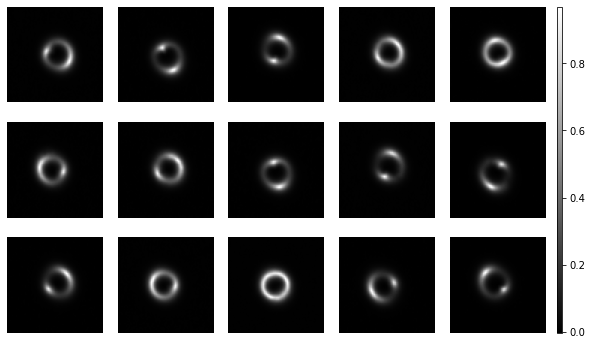

In [6]:
num_rows = 3
num_col = 5

n_samples = num_rows*num_col

# samples = sample_epsilon_v2(ema_model, n_samples=num_rows*num_col).cpu().detach()


# --- Plotting ---
fig = plt.figure(figsize=(10, 6))  # Increase width for colorbar
gs = gridspec.GridSpec(num_rows, num_col + 1, width_ratios=[1]*num_col + [0.05], wspace=0.1, hspace=0.2)

# for i in range(num_rows * num_col):
#     plt.subplot(num_rows, num_col, i + 1)
#     plt.imshow(samples[i, 0], cmap='gray')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# Plot images
for i in range(n_samples):
    row, col = divmod(i, num_col)
    ax = plt.subplot(gs[row, col])
    im = ax.imshow(samples[i, 0], cmap='gray')
    ax.axis('off')

# Colorbar in the last column of the grid
cbar_ax = plt.subplot(gs[:, -1])
plt.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()

In [8]:
from tqdm import tqdm

n_samples = 10000
batch_size = 100
all_samples = []

ema_model.eval()
with torch.no_grad():
    for i in tqdm(range(0, n_samples, batch_size)):
        current_batch = min(batch_size, n_samples - i)
        batch = sample_epsilon_v2(ema_model, n_samples=current_batch)  # should be on GPU
        all_samples.append(batch.cpu())  # move to CPU immediately

# Concatenate all and save as one file
samples = torch.cat(all_samples, dim=0)  # shape [1000, 1, 150, 150]
torch.save(samples, "generated_samples_model_II_550_epochs_lin+cos_10000.pt")
print("✅ Saved generated samples:", samples.shape)


 44%|████▍     | 44/100 [1:12:34<1:20:28, 86.23s/it]